<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500,>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде - "яблоки и груши":

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./data/apples_pears.csv")

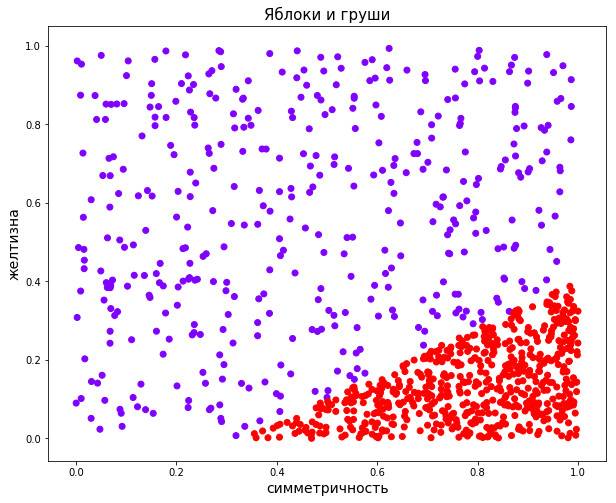

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [4]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [5]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);  ***

Рассмотрим второй путь (он чуть более user-friendly), к первому потом ещё вернёмся, и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [6]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [7]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [8]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.7238], grad_fn=<SigmoidBackward>)

Предскажем ещё необученным нейроном:

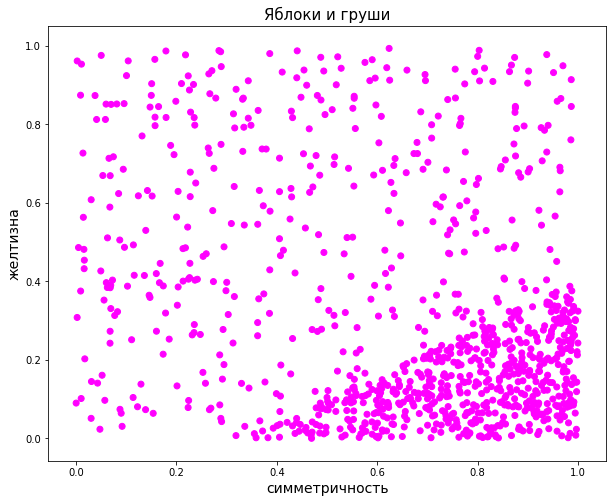

In [9]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [10]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [11]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

C:\Users\yushanov\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 262.63250732421875
1 258.6814270019531
2 254.73890686035156
3 250.81512451171875
4 246.91952514648438
5 243.0607452392578
6 239.24647521972656
7 235.4835205078125
8 231.77777099609375
9 228.13418579101562
10 224.55697631835938
11 221.04949951171875
12 217.61448669433594
13 214.2539825439453
14 210.96949768066406
15 207.7620391845703
16 204.63214111328125
17 201.57997131347656
18 198.6053466796875
19 195.7078094482422
20 192.88662719726562
21 190.14085388183594
22 187.46934509277344
23 184.87081909179688
24 182.34385681152344
25 179.88693237304688
26 177.49842834472656
27 175.17669677734375
28 172.9199981689453
29 170.72659301757812
30 168.59471130371094
31 166.52256774902344
32 164.50839233398438
33 162.55043029785156
34 160.64691162109375
35 158.796142578125
36 156.9964141845703
37 155.24606323242188
38 153.54348754882812
39 151.8870849609375
40 150.2753143310547
41 148.70669555664062
42 147.1797637939453
43 145.69308471679688
44 144.2453155517578
45 142.8351287841797
46 141.4612426

457 52.17392349243164
458 52.131011962890625
459 52.08823776245117
460 52.04560470581055
461 52.003108978271484
462 51.960758209228516
463 51.918540954589844
464 51.876461029052734
465 51.83451843261719
466 51.79270935058594
467 51.75103759765625
468 51.70949935913086
469 51.668094635009766
470 51.62682342529297
471 51.5856819152832
472 51.544673919677734
473 51.5037956237793
474 51.46304702758789
475 51.422428131103516
476 51.38193893432617
477 51.341575622558594
478 51.30133819580078
479 51.26123046875
480 51.221248626708984
481 51.18138885498047
482 51.141658782958984
483 51.102046966552734
484 51.06256103515625
485 51.023197174072266
486 50.98395538330078
487 50.9448356628418
488 50.90583038330078
489 50.86695098876953
490 50.828189849853516
491 50.789546966552734
492 50.75102233886719
493 50.71261215209961
494 50.674320220947266
495 50.636146545410156
496 50.598087310791016
497 50.56014633178711
498 50.522315979003906
499 50.48460006713867


Обучили. Предскажем теперь:

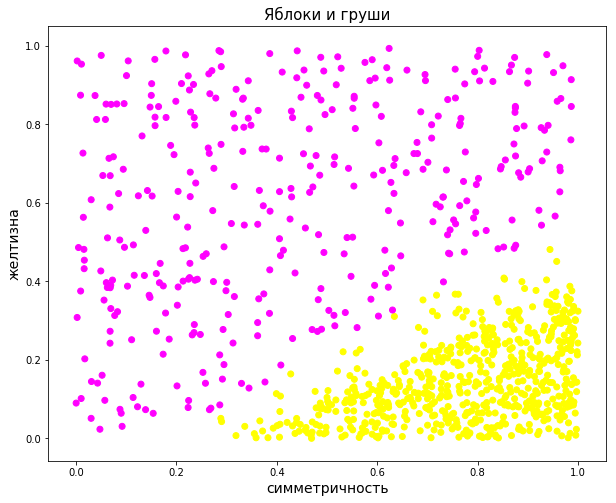

In [12]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

### Задача 1

1. Как видно по рисунку - качество не идеальное (даже перцептрон на нумпае лучше :). Добейтесь идеального качества (или очень близкого к идеальному), путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации);
2. Используйте функцию потерь `torch.nn.NLLLoss()` (== LogLoss) или `torch.nn.CrossEntropy()`, сделайте вывод о работе нейрона.

In [13]:
# Ваш код здесь (можно создавать много ячеек)
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.1  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(5000):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

C:\Users\yushanov\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 50.446998596191406
1 46.957733154296875
2 44.315345764160156
3 42.281837463378906
4 43.44660568237305
5 111.8508529663086
6 481.2552795410156
7 310.65399169921875
8 140.8931427001953
9 50.253944396972656
10 191.2478790283203
11 38.38887023925781
12 72.92308807373047
13 245.1659698486328
14 118.15349578857422
15 25.882787704467773
16 39.44624328613281
17 106.99791717529297
18 25.910537719726562
19 36.77426528930664
20 92.2738037109375
21 24.25789451599121
22 32.693302154541016
23 74.87197875976562
24 21.366363525390625
25 26.9381160736084
26 53.35935592651367
27 18.692596435546875
28 18.893659591674805
29 19.915952682495117
30 25.25725746154785
31 29.675539016723633
32 61.74966049194336
33 19.728822708129883
34 23.185510635375977
35 39.407840728759766
36 19.913854598999023
37 26.861202239990234
38 26.485363006591797
39 50.328678131103516
40 17.73352813720703
41 18.29766273498535
42 21.00074005126953
43 24.580472946166992
44 43.972984313964844
45 17.181838989257812
46 17.17317962646484

490 9.88038444519043
491 9.874547004699707
492 9.868722915649414
493 9.862908363342285
494 9.85710620880127
495 9.851316452026367
496 9.845538139343262
497 9.839771270751953
498 9.834016799926758
499 9.82827377319336
500 9.822541236877441
501 9.816821098327637
502 9.811111450195312
503 9.805414199829102
504 9.799727439880371
505 9.794052124023438
506 9.788389205932617
507 9.782735824584961
508 9.777095794677734
509 9.771464347839355
510 9.76584529876709
511 9.760238647460938
512 9.754640579223633
513 9.749054908752441
514 9.74347972869873
515 9.737916946411133
516 9.7323637008667
517 9.726822853088379
518 9.72128963470459
519 9.715768814086914
520 9.710260391235352
521 9.704760551452637
522 9.699272155761719
523 9.693792343139648
524 9.688325881958008
525 9.682870864868164
526 9.677424430847168
527 9.671987533569336
528 9.666563034057617
529 9.661148071289062
530 9.655743598937988
531 9.650350570678711
532 9.644967079162598
533 9.639593124389648
534 9.634230613708496
535 9.628877639770

1004 7.8619465827941895
1005 7.859239101409912
1006 7.856535911560059
1007 7.853836536407471
1008 7.851138114929199
1009 7.848443984985352
1010 7.845752239227295
1011 7.8430657386779785
1012 7.84037971496582
1013 7.837697982788086
1014 7.83501672744751
1015 7.832342624664307
1016 7.829668998718262
1017 7.826998233795166
1018 7.824331283569336
1019 7.821667194366455
1020 7.819005966186523
1021 7.816347599029541
1022 7.813692092895508
1023 7.811039447784424
1024 7.80839204788208
1025 7.805744647979736
1026 7.803100109100342
1027 7.800460338592529
1028 7.79782247543335
1029 7.795187950134277
1030 7.792555332183838
1031 7.789927005767822
1032 7.787301063537598
1033 7.784677982330322
1034 7.7820587158203125
1035 7.779441833496094
1036 7.776826858520508
1037 7.774214744567871
1038 7.771607398986816
1039 7.7690019607543945
1040 7.766398906707764
1041 7.76379919052124
1042 7.761203289031982
1043 7.758608818054199
1044 7.756017684936523
1045 7.753429412841797
1046 7.750844478607178
1047 7.74826

1523 6.766181945800781
1524 6.764522552490234
1525 6.762861728668213
1526 6.761202335357666
1527 6.759545803070068
1528 6.757889270782471
1529 6.756237506866455
1530 6.754581928253174
1531 6.752931118011475
1532 6.751278400421143
1533 6.749630928039551
1534 6.747983455657959
1535 6.746337413787842
1536 6.744690895080566
1537 6.743045806884766
1538 6.741402626037598
1539 6.739760398864746
1540 6.7381205558776855
1541 6.736481189727783
1542 6.734844207763672
1543 6.733206748962402
1544 6.731571674346924
1545 6.7299370765686035
1546 6.728305339813232
1547 6.726675033569336
1548 6.725045204162598
1549 6.723415851593018
1550 6.72178840637207
1551 6.720162868499756
1552 6.718536853790283
1553 6.716912746429443
1554 6.715290546417236
1555 6.713668346405029
1556 6.712048053741455
1557 6.7104291915893555
1558 6.7088117599487305
1559 6.70719575881958
1560 6.7055816650390625
1561 6.703967571258545
1562 6.70235538482666
1563 6.700744152069092
1564 6.699134349822998
1565 6.697525501251221
1566 6.69

2031 6.060055255889893
2032 6.0588860511779785
2033 6.057719707489014
2034 6.056554317474365
2035 6.055389404296875
2036 6.054224491119385
2037 6.053060054779053
2038 6.051897048950195
2039 6.0507330894470215
2040 6.0495710372924805
2041 6.048410415649414
2042 6.0472493171691895
2043 6.046090602874756
2044 6.0449299812316895
2045 6.043773174285889
2046 6.04261589050293
2047 6.041457653045654
2048 6.040301322937012
2049 6.039146423339844
2050 6.03799295425415
2051 6.036837577819824
2052 6.0356831550598145
2053 6.0345306396484375
2054 6.033378601074219
2055 6.032227993011475
2056 6.031075477600098
2057 6.029928207397461
2058 6.028777599334717
2059 6.0276288986206055
2060 6.026480674743652
2061 6.025333881378174
2062 6.024187088012695
2063 6.023040294647217
2064 6.021897315979004
2065 6.020751953125
2066 6.019608020782471
2067 6.018464088439941
2068 6.017322540283203
2069 6.016180992126465
2070 6.015039443969727
2071 6.013899326324463
2072 6.01276159286499
2073 6.011621952056885
2074 6.01

2543 5.5417985916137695
2544 5.540919303894043
2545 5.540040493011475
2546 5.539161205291748
2547 5.538283348083496
2548 5.537407398223877
2549 5.536528587341309
2550 5.535650730133057
2551 5.534776210784912
2552 5.533901214599609
2553 5.533024311065674
2554 5.532149314880371
2555 5.531274795532227
2556 5.530400276184082
2557 5.529526710510254
2558 5.528653621673584
2559 5.527779579162598
2560 5.526907920837402
2561 5.526035785675049
2562 5.525163650512695
2563 5.524293422698975
2564 5.523421287536621
2565 5.52255392074585
2566 5.5216827392578125
2567 5.520812511444092
2568 5.519944190979004
2569 5.519075870513916
2570 5.518208980560303
2571 5.517341136932373
2572 5.516472339630127
2573 5.51560640335083
2574 5.514739990234375
2575 5.513874053955078
2576 5.513009071350098
2577 5.512142181396484
2578 5.511279106140137
2579 5.5104146003723145
2580 5.509550094604492
2581 5.5086870193481445
2582 5.5078253746032715
2583 5.506961822509766
2584 5.506099224090576
2585 5.5052385330200195
2586 5.

3060 5.138528347015381
3061 5.137836933135986
3062 5.137144565582275
3063 5.136451721191406
3064 5.1357598304748535
3065 5.135068416595459
3066 5.134377956390381
3067 5.13368558883667
3068 5.132996559143066
3069 5.132304668426514
3070 5.1316142082214355
3071 5.130923748016357
3072 5.130234718322754
3073 5.129545211791992
3074 5.128857612609863
3075 5.128167629241943
3076 5.127479553222656
3077 5.126791477203369
3078 5.126101970672607
3079 5.125417232513428
3080 5.124728679656982
3081 5.12404203414917
3082 5.123355865478516
3083 5.1226677894592285
3084 5.121983051300049
3085 5.121297359466553
3086 5.120612144470215
3087 5.119925498962402
3088 5.119240760803223
3089 5.118556499481201
3090 5.117872714996338
3091 5.117186546325684
3092 5.1165056228637695
3093 5.115820407867432
3094 5.115139007568359
3095 5.1144537925720215
3096 5.113772869110107
3097 5.113090991973877
3098 5.11240816116333
3099 5.111726760864258
3100 5.111045837402344
3101 5.110365390777588
3102 5.109682559967041
3103 5.10

3570 4.819276332855225
3571 4.818711757659912
3572 4.818146705627441
3573 4.817582130432129
3574 4.817015171051025
3575 4.816447734832764
3576 4.815885066986084
3577 4.8153204917907715
3578 4.814756870269775
3579 4.814191818237305
3580 4.813626289367676
3581 4.81306266784668
3582 4.812498092651367
3583 4.8119354248046875
3584 4.811372756958008
3585 4.8108086585998535
3586 4.810245990753174
3587 4.809682369232178
3588 4.809121131896973
3589 4.808558464050293
3590 4.8079962730407715
3591 4.80743408203125
3592 4.806874752044678
3593 4.806311130523682
3594 4.805750370025635
3595 4.805188179016113
3596 4.80462646484375
3597 4.804066181182861
3598 4.803506374359131
3599 4.8029465675354
3600 4.8023858070373535
3601 4.801826477050781
3602 4.801266670227051
3603 4.800705432891846
3604 4.800147533416748
3605 4.799588680267334
3606 4.799029350280762
3607 4.798470973968506
3608 4.797913074493408
3609 4.7973551750183105
3610 4.796797275543213
3611 4.796238899230957
3612 4.795681953430176
3613 4.795

4086 4.552308559417725
4087 4.551835060119629
4088 4.551362037658691
4089 4.550890922546387
4090 4.550416946411133
4091 4.549942493438721
4092 4.549469947814941
4093 4.54899787902832
4094 4.548527717590332
4095 4.548055648803711
4096 4.547584533691406
4097 4.547111988067627
4098 4.546640872955322
4099 4.546169281005859
4100 4.545695781707764
4101 4.54522705078125
4102 4.5447564125061035
4103 4.544284820556641
4104 4.543814182281494
4105 4.543344497680664
4106 4.54287576675415
4107 4.542402267456055
4108 4.541934967041016
4109 4.541464805603027
4110 4.5409955978393555
4111 4.54052734375
4112 4.540055274963379
4113 4.539585590362549
4114 4.539117336273193
4115 4.53864860534668
4116 4.538179397583008
4117 4.537712097167969
4118 4.537242412567139
4119 4.536774635314941
4120 4.536306858062744
4121 4.535839557647705
4122 4.535371780395508
4123 4.5349040031433105
4124 4.534435272216797
4125 4.533967018127441
4126 4.533502101898193
4127 4.533035755157471
4128 4.532566070556641
4129 4.532100677

4599 4.328159809112549
4600 4.327756404876709
4601 4.327353477478027
4602 4.326948642730713
4603 4.326545238494873
4604 4.326142311096191
4605 4.32573938369751
4606 4.325336456298828
4607 4.324934005737305
4608 4.324531078338623
4609 4.3241286277771
4610 4.323725700378418
4611 4.323325157165527
4612 4.3229217529296875
4613 4.322519779205322
4614 4.322117328643799
4615 4.32171630859375
4616 4.321315288543701
4617 4.320911407470703
4618 4.3205108642578125
4619 4.320108413696289
4620 4.31970739364624
4621 4.319307804107666
4622 4.318905830383301
4623 4.318504810333252
4624 4.318103790283203
4625 4.31770133972168
4626 4.317302703857422
4627 4.316901683807373
4628 4.316500186920166
4629 4.316100597381592
4630 4.315701961517334
4631 4.315299987792969
4632 4.314899444580078
4633 4.314503192901611
4634 4.314101219177246
4635 4.3137006759643555
4636 4.313302516937256
4637 4.312902450561523
4638 4.312504768371582
4639 4.31210470199585
4640 4.311707496643066
4641 4.311305999755859
4642 4.31090879

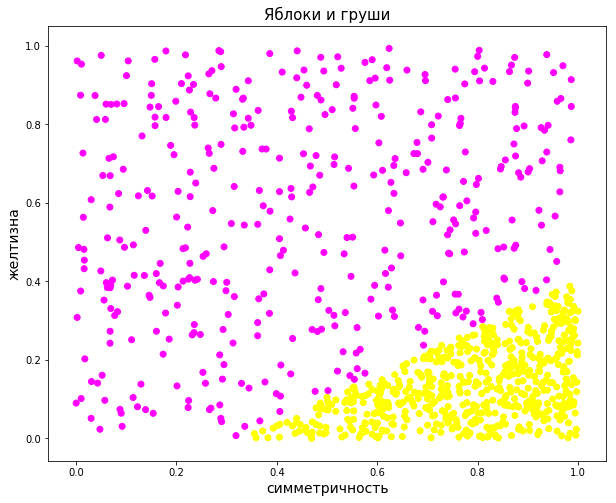

In [14]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [15]:
# torch.nn.NLLLoss()
#y
y.type_as(torch.LongTensor())

tensor([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],

In [16]:
loss_fn = torch.nn.NLLLoss()

learning_rate = 0.01  # == 1e-3
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)

for t in range(500):
    y_pred = neuron(X)

    loss = loss_fn(y_pred,  torch.max(y, 1)[1])
    print('{} {}'.format(t, loss.data))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 -0.5831295847892761
1 -0.5831327438354492
2 -0.5831356048583984
3 -0.5831384062767029
4 -0.5831414461135864
5 -0.5831441283226013
6 -0.5831470489501953
7 -0.5831500291824341
8 -0.5831528306007385
9 -0.5831561088562012
10 -0.5831586122512817
11 -0.5831615328788757
12 -0.5831648111343384
13 -0.5831677317619324
14 -0.5831706523895264
15 -0.5831735134124756
16 -0.5831763744354248
17 -0.583179235458374
18 -0.5831823945045471
19 -0.5831853151321411
20 -0.5831881761550903
21 -0.5831912159919739
22 -0.5831940174102783
23 -0.5831965208053589
24 -0.5831998586654663
25 -0.5832027792930603
26 -0.5832056999206543
27 -0.5832085013389587
28 -0.5832115411758423
29 -0.5832144021987915
30 -0.5832173824310303
31 -0.5832200646400452
32 -0.5832231640815735
33 -0.5832261443138123
34 -0.5832290649414062
35 -0.5832318663597107
36 -0.5832347273826599
37 -0.5832377672195435
38 -0.5832406878471375
39 -0.5832439064979553
40 -0.5832467675209045
41 -0.5832495093345642
42 -0.5832523107528687
43 -0.5832551717758179

465 -0.5844395160675049
466 -0.5844422578811646
467 -0.5844449400901794
468 -0.5844475626945496
469 -0.5844503045082092
470 -0.5844528675079346
471 -0.5844556093215942
472 -0.5844585299491882
473 -0.5844610333442688
474 -0.5844638347625732
475 -0.5844665169715881
476 -0.5844690799713135
477 -0.5844717025756836
478 -0.5844746232032776
479 -0.5844771265983582
480 -0.5844798684120178
481 -0.5844825506210327
482 -0.5844852924346924
483 -0.584488034248352
484 -0.5844905376434326
485 -0.5844932794570923
486 -0.5844959616661072
487 -0.5844985246658325
488 -0.5845012664794922
489 -0.5845037698745728
490 -0.5845065712928772
491 -0.5845093727111816
492 -0.584511935710907
493 -0.5845146775245667
494 -0.5845173001289368
495 -0.5845200419425964
496 -0.5845226645469666
497 -0.5845253467559814
498 -0.5845280289649963
499 -0.5845307111740112


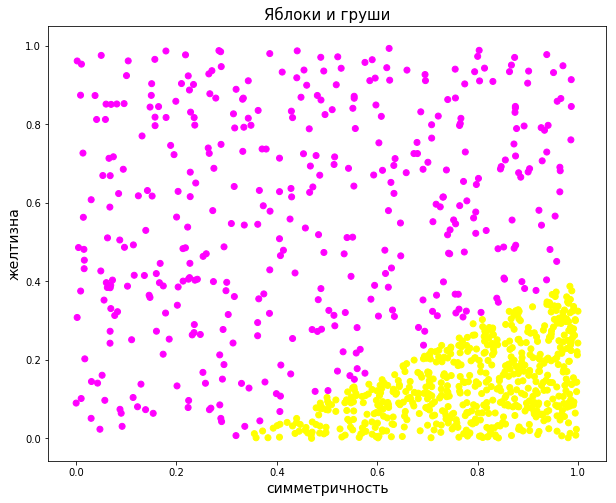

In [17]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [18]:
# torch.nn.CrossEntropy()

In [19]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 0.001  # == 1e-3
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)

for t in range(500):
    y_pred = neuron(X)

    loss = loss_fn(y_pred, torch.max(y, 1)[1])
    print('{} {}'.format(t, loss.data))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

C:\Users\yushanov\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

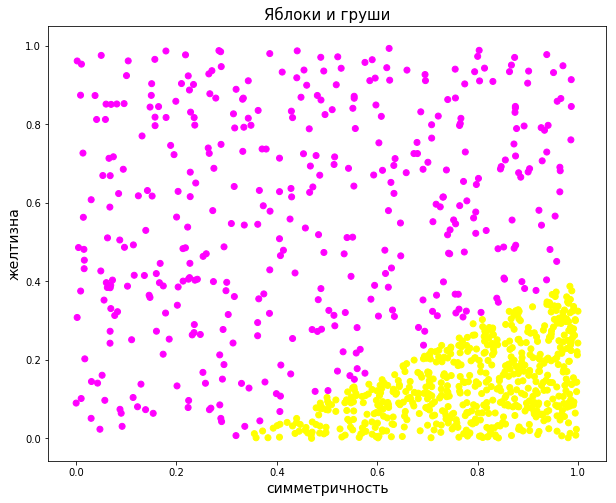

In [20]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

Круто. Нейрон работет, отличает яблоки от груш (Вы ведь этого добились, правда?). Но так ли он силён? Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

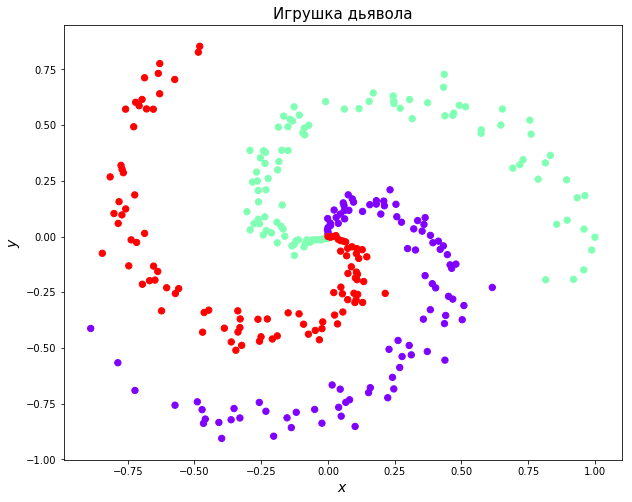

In [85]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear
import numpy as np

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable() (без этого градиенты не посчитать):

In [86]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [87]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


В атаку, наш славный нейрон с сигмоидой (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [88]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    y_pred = neuron(X)

    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

C:\Users\yushanov\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 292.5989685058594
1 292.1833190917969
2 291.7743835449219
3 291.37213134765625
4 290.9762268066406
5 290.5865783691406
6 290.20294189453125
7 289.8255310058594
8 289.4539794921875
9 289.08837890625
10 288.728271484375
11 288.3736572265625
12 288.0245056152344
13 287.68060302734375
14 287.34210205078125
15 287.008544921875
16 286.679931640625
17 286.3563537597656
18 286.03729248046875
19 285.7232360839844
20 285.41363525390625
21 285.10845947265625
22 284.80792236328125
23 284.5115051269531
24 284.2193908691406
25 283.931396484375
26 283.6473083496094
27 283.36737060546875
28 283.09130859375
29 282.8189392089844
30 282.55047607421875
31 282.2854919433594
32 282.02423095703125
33 281.76641845703125
34 281.511962890625
35 281.2608642578125
36 281.0132141113281
37 280.7688293457031
38 280.5275573730469
39 280.2893981933594
40 280.0540466308594
41 279.82208251953125
42 279.5928955078125
43 279.3665771484375
44 279.142822265625
45 278.922119140625
46 278.70404052734375
47 278.4886474609375

In [89]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

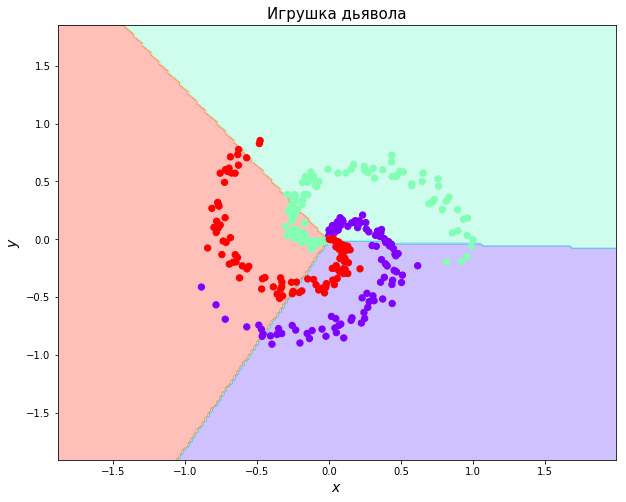

In [90]:
# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

### Задача 2

Меняя все известные Вам способы улучшения нейросети, постарайтесь добиться лучшего качества здесь. (**архитектуру менять нельзя**, мы же хотим добиться победы одним нейроном (слоем)).

In [139]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [140]:
# Ваш код здесь (можно (и нужно) создавать несколько ячеек)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 1e-3
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)

for t in range(5000):
    y_pred = neuron(X)
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

C:\Users\yushanov\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 389.68939208984375
1 382.45404052734375
2 375.8653869628906
3 369.8343505859375
4 364.2852783203125
5 359.15496826171875
6 354.3900451660156
7 349.9461975097656
8 345.7852478027344
9 341.8747253417969
10 338.1877136230469
11 334.70025634765625
12 331.3924865722656
13 328.247314453125
14 325.249755859375
15 322.387451171875
16 319.64898681640625
17 317.0243835449219
18 314.5060119628906
19 312.0859069824219
20 309.75811767578125
21 307.516357421875
22 305.3559875488281
23 303.27166748046875
24 301.26025390625
25 299.31719970703125
26 297.439453125
27 295.6238708496094
28 293.8675842285156
29 292.1678161621094
30 290.5224609375
31 288.9288330078125
32 287.3844909667969
33 285.8882751464844
34 284.4377136230469
35 283.0312194824219
36 281.6670227050781
37 280.34344482421875
38 279.0588684082031
39 277.8121032714844
40 276.6018981933594
41 275.4263916015625
42 274.2846374511719
43 273.1754150390625
44 272.0977478027344
45 271.04998779296875
46 270.03167724609375
47 269.0415344238281
48 2

424 221.67784118652344
425 221.67129516601562
426 221.66506958007812
427 221.65869140625
428 221.652587890625
429 221.6461639404297
430 221.64004516601562
431 221.63409423828125
432 221.6279754638672
433 221.6219482421875
434 221.61605834960938
435 221.61009216308594
436 221.60421752929688
437 221.5984344482422
438 221.5926055908203
439 221.58702087402344
440 221.58148193359375
441 221.57582092285156
442 221.5701446533203
443 221.5646514892578
444 221.55923461914062
445 221.55386352539062
446 221.54844665527344
447 221.54306030273438
448 221.53775024414062
449 221.53237915039062
450 221.52732849121094
451 221.5220947265625
452 221.5169677734375
453 221.5118408203125
454 221.5067596435547
455 221.50189208984375
456 221.49684143066406
457 221.49197387695312
458 221.48704528808594
459 221.48220825195312
460 221.47747802734375
461 221.4727325439453
462 221.4680633544922
463 221.4633026123047
464 221.45864868164062
465 221.4539337158203
466 221.4495391845703
467 221.44485473632812
468 221.4

1012 220.8571319580078
1013 220.85711669921875
1014 220.85690307617188
1015 220.85679626464844
1016 220.85678100585938
1017 220.85671997070312
1018 220.85659790039062
1019 220.8565673828125
1020 220.85659790039062
1021 220.85629272460938
1022 220.85621643066406
1023 220.85598754882812
1024 220.85606384277344
1025 220.85598754882812
1026 220.85585021972656
1027 220.85581970214844
1028 220.85572814941406
1029 220.8556671142578
1030 220.85557556152344
1031 220.85545349121094
1032 220.85531616210938
1033 220.85531616210938
1034 220.855224609375
1035 220.85525512695312
1036 220.8551483154297
1037 220.85494995117188
1038 220.8549041748047
1039 220.8548126220703
1040 220.8548583984375
1041 220.85458374023438
1042 220.85459899902344
1043 220.8545684814453
1044 220.85446166992188
1045 220.85438537597656
1046 220.85430908203125
1047 220.854248046875
1048 220.8540802001953
1049 220.8540496826172
1050 220.85401916503906
1051 220.85397338867188
1052 220.85386657714844
1053 220.8538055419922
1054 22

1506 220.8434295654297
1507 220.84336853027344
1508 220.84341430664062
1509 220.84326171875
1510 220.84329223632812
1511 220.84329223632812
1512 220.84336853027344
1513 220.84332275390625
1514 220.84329223632812
1515 220.84347534179688
1516 220.84332275390625
1517 220.84324645996094
1518 220.84326171875
1519 220.84332275390625
1520 220.8433074951172
1521 220.8434295654297
1522 220.84332275390625
1523 220.8433074951172
1524 220.8433380126953
1525 220.84332275390625
1526 220.84329223632812
1527 220.8433380126953
1528 220.84332275390625
1529 220.8433074951172
1530 220.84329223632812
1531 220.84324645996094
1532 220.84324645996094
1533 220.8433380126953
1534 220.84324645996094
1535 220.84324645996094
1536 220.84326171875
1537 220.84324645996094
1538 220.84335327148438
1539 220.8433837890625
1540 220.84326171875
1541 220.84327697753906
1542 220.84320068359375
1543 220.84326171875
1544 220.84326171875
1545 220.84326171875
1546 220.84336853027344
1547 220.84324645996094
1548 220.8432769775390

2083 220.84283447265625
2084 220.84280395507812
2085 220.8428497314453
2086 220.8428497314453
2087 220.8428192138672
2088 220.8428192138672
2089 220.84275817871094
2090 220.84274291992188
2091 220.84271240234375
2092 220.84268188476562
2093 220.84271240234375
2094 220.84271240234375
2095 220.84268188476562
2096 220.8426971435547
2097 220.84271240234375
2098 220.84266662597656
2099 220.84268188476562
2100 220.84268188476562
2101 220.84274291992188
2102 220.84275817871094
2103 220.84271240234375
2104 220.8426971435547
2105 220.8427276611328
2106 220.84271240234375
2107 220.84274291992188
2108 220.84271240234375
2109 220.84274291992188
2110 220.84275817871094
2111 220.84275817871094
2112 220.8427734375
2113 220.84280395507812
2114 220.84275817871094
2115 220.84274291992188
2116 220.84274291992188
2117 220.84278869628906
2118 220.84278869628906
2119 220.84283447265625
2120 220.8428192138672
2121 220.8428192138672
2122 220.8428192138672
2123 220.8428192138672
2124 220.8428955078125
2125 220

2462 220.84278869628906
2463 220.84275817871094
2464 220.84278869628906
2465 220.84278869628906
2466 220.8427734375
2467 220.8427734375
2468 220.84275817871094
2469 220.8427734375
2470 220.84280395507812
2471 220.84278869628906
2472 220.84278869628906
2473 220.84278869628906
2474 220.8428192138672
2475 220.84278869628906
2476 220.8428192138672
2477 220.8428192138672
2478 220.8428192138672
2479 220.84280395507812
2480 220.8428192138672
2481 220.84283447265625
2482 220.8428497314453
2483 220.84288024902344
2484 220.8428497314453
2485 220.84286499023438
2486 220.84286499023438
2487 220.84283447265625
2488 220.84283447265625
2489 220.8428497314453
2490 220.8428497314453
2491 220.84280395507812
2492 220.84275817871094
2493 220.8428192138672
2494 220.8428192138672
2495 220.84280395507812
2496 220.8428192138672
2497 220.8428192138672
2498 220.84280395507812
2499 220.84278869628906
2500 220.8427734375
2501 220.84275817871094
2502 220.8427734375
2503 220.8427734375
2504 220.8427734375
2505 220.

3027 220.84274291992188
3028 220.84275817871094
3029 220.84274291992188
3030 220.8427276611328
3031 220.84275817871094
3032 220.84275817871094
3033 220.84275817871094
3034 220.84275817871094
3035 220.8427734375
3036 220.8427734375
3037 220.8427734375
3038 220.84275817871094
3039 220.8427734375
3040 220.8427734375
3041 220.8427734375
3042 220.8427734375
3043 220.8427734375
3044 220.8427734375
3045 220.84278869628906
3046 220.84278869628906
3047 220.84275817871094
3048 220.84275817871094
3049 220.84275817871094
3050 220.84278869628906
3051 220.84278869628906
3052 220.84278869628906
3053 220.84278869628906
3054 220.84278869628906
3055 220.84275817871094
3056 220.8427734375
3057 220.8427734375
3058 220.8427734375
3059 220.84278869628906
3060 220.8427734375
3061 220.8427734375
3062 220.8427734375
3063 220.8427734375
3064 220.8427734375
3065 220.8427734375
3066 220.8427734375
3067 220.8427734375
3068 220.8427734375
3069 220.8427734375
3070 220.8427734375
3071 220.8427734375
3072 220.84278869

3601 220.84278869628906
3602 220.84278869628906
3603 220.84278869628906
3604 220.84278869628906
3605 220.84278869628906
3606 220.84278869628906
3607 220.84278869628906
3608 220.84278869628906
3609 220.84278869628906
3610 220.84278869628906
3611 220.84278869628906
3612 220.84278869628906
3613 220.84278869628906
3614 220.84278869628906
3615 220.84278869628906
3616 220.84278869628906
3617 220.84278869628906
3618 220.84278869628906
3619 220.84278869628906
3620 220.84278869628906
3621 220.84278869628906
3622 220.84278869628906
3623 220.84278869628906
3624 220.84278869628906
3625 220.84278869628906
3626 220.84278869628906
3627 220.84278869628906
3628 220.84278869628906
3629 220.84278869628906
3630 220.84278869628906
3631 220.84278869628906
3632 220.84278869628906
3633 220.84278869628906
3634 220.84278869628906
3635 220.84278869628906
3636 220.84278869628906
3637 220.84278869628906
3638 220.84278869628906
3639 220.84278869628906
3640 220.84278869628906
3641 220.84278869628906
3642 220.8427886

4165 220.84278869628906
4166 220.84278869628906
4167 220.84278869628906
4168 220.84278869628906
4169 220.84278869628906
4170 220.84278869628906
4171 220.84278869628906
4172 220.84278869628906
4173 220.84278869628906
4174 220.84278869628906
4175 220.84278869628906
4176 220.84278869628906
4177 220.84278869628906
4178 220.84278869628906
4179 220.84278869628906
4180 220.84278869628906
4181 220.84278869628906
4182 220.84278869628906
4183 220.84278869628906
4184 220.84278869628906
4185 220.84278869628906
4186 220.84278869628906
4187 220.84278869628906
4188 220.84278869628906
4189 220.84278869628906
4190 220.84278869628906
4191 220.84278869628906
4192 220.84278869628906
4193 220.84278869628906
4194 220.84278869628906
4195 220.84278869628906
4196 220.84278869628906
4197 220.84278869628906
4198 220.84278869628906
4199 220.84278869628906
4200 220.84278869628906
4201 220.84278869628906
4202 220.84278869628906
4203 220.84278869628906
4204 220.84278869628906
4205 220.84278869628906
4206 220.8427886

4725 220.84278869628906
4726 220.84278869628906
4727 220.84278869628906
4728 220.84278869628906
4729 220.84278869628906
4730 220.84278869628906
4731 220.84278869628906
4732 220.84278869628906
4733 220.84278869628906
4734 220.84278869628906
4735 220.84278869628906
4736 220.84278869628906
4737 220.84278869628906
4738 220.84278869628906
4739 220.84278869628906
4740 220.84278869628906
4741 220.84278869628906
4742 220.84278869628906
4743 220.84278869628906
4744 220.84278869628906
4745 220.84278869628906
4746 220.84278869628906
4747 220.84278869628906
4748 220.84278869628906
4749 220.84278869628906
4750 220.84278869628906
4751 220.84278869628906
4752 220.84278869628906
4753 220.84278869628906
4754 220.84278869628906
4755 220.84278869628906
4756 220.84278869628906
4757 220.84278869628906
4758 220.84278869628906
4759 220.84278869628906
4760 220.84278869628906
4761 220.84278869628906
4762 220.84278869628906
4763 220.84278869628906
4764 220.84278869628906
4765 220.84278869628906
4766 220.8427886

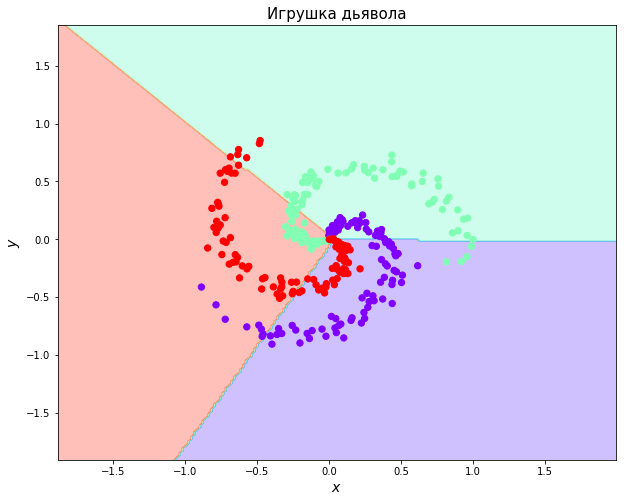

In [141]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*